# Load Required Libraries

In [11]:
# install.packages("BiocManager") 
# BiocManager::install("WGCNA")
library(WGCNA)
#BiocManager::install("topGO")
library(topGO)
library(dplyr)
library(reshape2)
# install.packages("dhga")
library(dhga)
#install.packages("beepr")
library(beepr)
#increase plot area 
options(repr.plot.width=16, repr.plot.height=8)

In [12]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/paulyeta/.conda/envs/r4-base/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] beepr_1.3             dhga_0.1              VennDiagram_1.7.3    
 [4] futile.logger_1.4.3   reshape2_1.4.4        dplyr_1.0.9          
 [7] topGO_2.42.0          SparseM_1.81          GO.db_3.12.1         
[10] AnnotationDbi_1.52.0  IRanges_2.24.1        S4Ve

# Data Input and Cleaning
## Load and Import Data

In [14]:
# Read in the data
# Columns should be genes, Rows should be samples
options(stringsAsFactors = FALSE)
allData = read.csv("../Reference_Files/Network_Analysis/fpkm.36lines.txt", sep = " ")
rownames(allData) <- allData$Genes
datExpr = as.data.frame(t(allData[-1]))
rownames(datExpr) = gsub(".RG.bam", "", rownames(datExpr))
head(datExpr)
dim(datExpr)

ADF43159.1 ADF43160.1 ADF43161.1 ADF43162.1 ADF43163.1 ADF43164.1
X23_00_1 0.6463819   6.453559  4.694451   45.19839   1.5678370  3.2207649 
X23_00_2 0.7206985   5.678646  3.179284   47.48910   0.8512468  0.8449568 
X23_00_3 1.2623981   7.293855  8.149658   35.92979   2.0361259  4.8754683 
X23_05_1 1.2350549  14.351830  3.251458   30.27782   2.9264170  6.6546172 
X23_05_2 1.4448040  16.079879  6.874504   39.41996   1.7606931  7.0014871 
X23_05_3 1.9649550  18.538271  7.360521   51.00341   1.8215097  5.4607180 
         ADF43165.1 ADF43166.1 ADF43167.1 ADF43168.1 ⋯ g9990    g9991    
X23_00_1 1.8760840  0.8249619  0.1962231  0.6117076  ⋯ 7.461870 0.4491209
X23_00_2 0.9562438  0.7358483  0.0000000  0.6944382  ⋯ 9.092336 0.4006062
X23_00_3 2.4632157  1.1372955  0.1803426  1.3288401  ⋯ 9.766491 1.0319330
X23_05_1 3.2251148  2.0390914  0.6381743  1.6639038  ⋯ 6.782085 1.6067385
X23_05_2 2.8755124  0.9834502  1.2475768  1.8562125  ⋯ 6.962780 1.6285212
X23_05_3 2.5749727  1.1393578  0.8247959  1.5360572  ⋯ 6.761060 1.1293187
         g9992    g9993    g9994     g9995    g9996    g9997    g9998   
X23_00_1 7.194420 27.36460 0.9176601 2.136383 1.862785 3.746077 5.038063
X23_00_2 8.811771 30.34868 0.8011175 2.648472 2.764947 4.994906 6.103579
X23_00_3 8.783330 25.06978 1.7585645 2.429395 2.862298 5.146609 7.394704
X23_05_1 5.308280 19.06686 1.7906980 1.578051 1.533511 3.567077 4.035171
X23_05_2 6.955139 12.24906 2.0792947 2.000042 1.827415 4.910799 6.125477
X23_05_3 6.963749 10.47729 1.6296608 1.815566 1.572982 3.872753 6.163393
         g9999   
X23_00_1 2.918422
X23_00_2 3.565210
X23_00_3 4.606441
X23_05_1 4.002959
X23_05_2 3.630362
X23_05_3 5.181166

[1]    36 18945

## remove bad genes
This function checks data for missing entries, entries with weights below a threshold, and zero-variance genes, and returns a list of samples and genes that pass criteria on maximum number of missing or low weight values. If necessary, the filtering is iterated. We'll then have to remove the "bad" genes/data entries

https://www.rdocumentation.org/packages/WGCNA/versions/1.63/topics/goodSamplesGenes

In [15]:
gsg = goodSamplesGenes(datExpr, verbose = 5)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 1255 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

In [16]:
if (!gsg$allOK)
{
  datExpr = datExpr[gsg$goodSamples, gsg$goodGenes]
}
dim(datExpr)

[1]    36 17690

## Cluster the samples

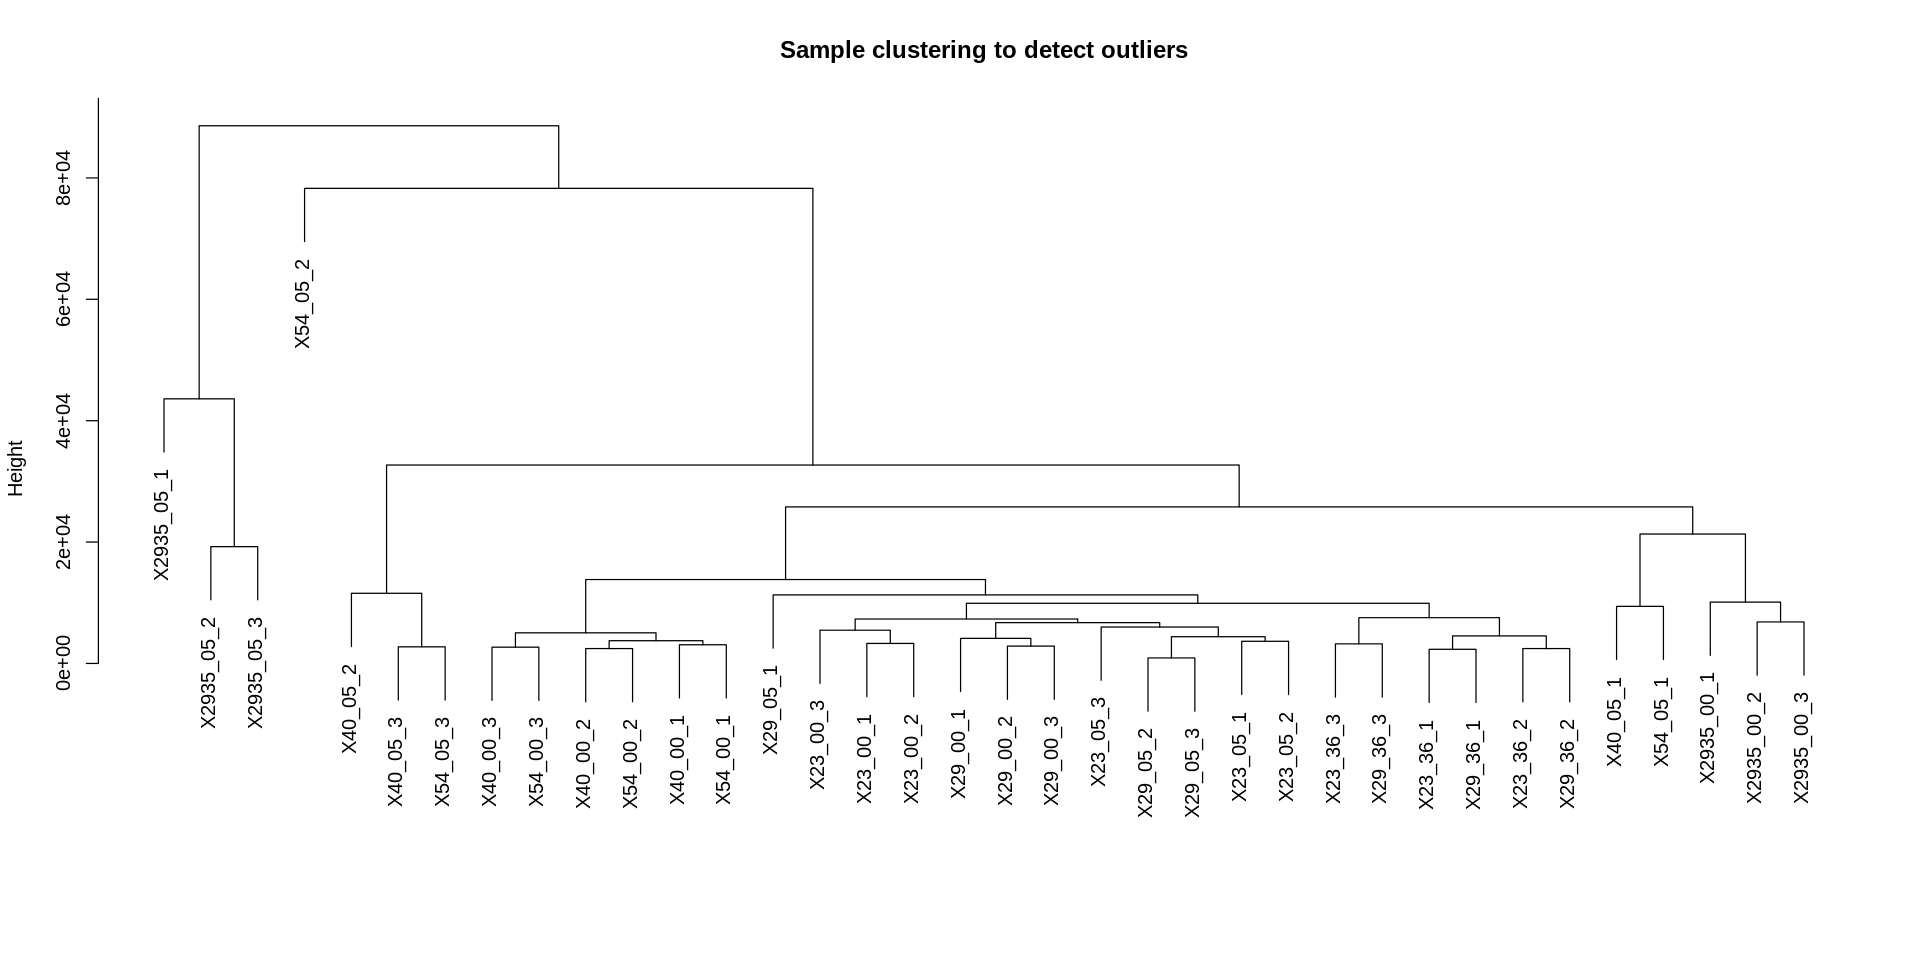

In [17]:
sampleTree = hclust(dist(datExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [18]:
nGenes = ncol(datExpr)
nGenes
nSamples = nrow(datExpr)
nSamples

[1] 17690

[1] 36

## Load Trait Data

In [19]:
traitData = read.csv("../Reference_Files/Network_Analysis/ClinicalTraitsBinary.csv")
head(traitData)

Samples  Conc.0 Conc.5 Conc.36 Evolved Ancestor X29 X23 X2935 X40 X54
1 X23_00_1 1      0      0       1       0        0   1   0     0   0  
2 X23_00_2 1      0      0       1       0        0   1   0     0   0  
3 X23_00_3 1      0      0       1       0        0   1   0     0   0  
4 X29_00_1 1      0      0       1       0        1   0   0     0   0  
5 X29_00_2 1      0      0       1       0        1   0   0     0   0  
6 X29_00_3 1      0      0       1       0        1   0   0     0   0

In [20]:
traitRows = match(rownames(datExpr), traitData$Samples)
datTraits = traitData[traitRows, -1]
rownames(datTraits) <- traitData[traitRows, 1]
head(datTraits)
collectGarbage()

Conc.0 Conc.5 Conc.36 Evolved Ancestor X29 X23 X2935 X40 X54
X23_00_1 1      0      0       1       0        0   1   0     0   0  
X23_00_2 1      0      0       1       0        0   1   0     0   0  
X23_00_3 1      0      0       1       0        0   1   0     0   0  
X23_05_1 0      1      0       1       0        0   1   0     0   0  
X23_05_2 0      1      0       1       0        0   1   0     0   0  
X23_05_3 0      1      0       1       0        0   1   0     0   0

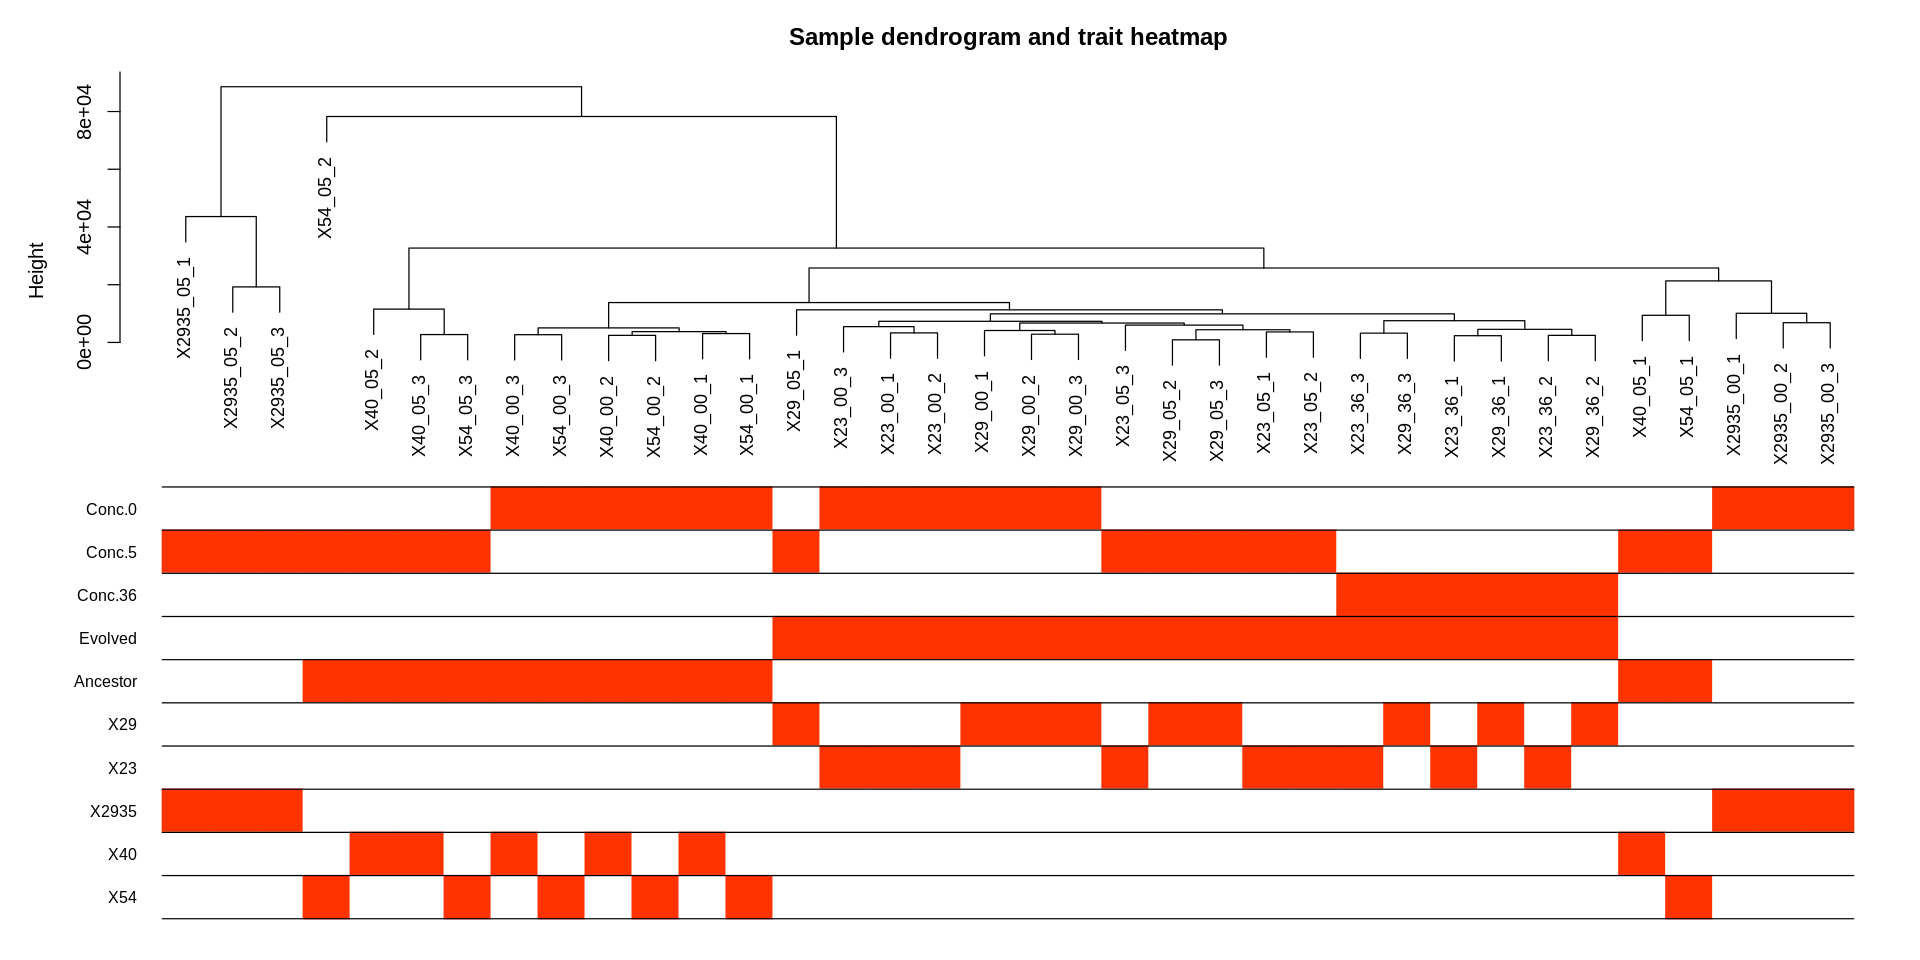

In [21]:
#Recluster samples
sampleTree2 = hclust(dist(datExpr), method = "average")
traitColors = numbers2colors(datTraits, signed = FALSE)
plotDendroAndColors(sampleTree2, traitColors,
                  groupLabels = names(datTraits),
                  main = "Sample dendrogram and trait heatmap")

# Network Consturction and Module detection

In [22]:
powers = c(c(1:10), seq(from = 12, to=20, by=2))
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 2)

pickSoftThreshold: will use block size 2529.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2529 of 17690


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   ..working on genes 2530 through 5058 of 17690
   ..working on genes 5059 through 7587 of 17690
   ..working on genes 7588 through 10116 of 17690
   ..working on genes 10117 through 12645 of 17690
   ..working on genes 12646 through 15174 of 17690
   ..working on genes 15175 through 17690 of 17690
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.7090  2.270          0.871  5390.0   5540.00   7520
2      2   0.1570  0.453          0.733  2410.0   2450.00   4350
3      3   0.0569 -0.232          0.842  1290.0   1270.00   2890
4      4   0.3490 -0.658          0.944   775.0    730.00   2100
5      5   0.5650 -0.959          0.977   502.0    448.00   1610
6      6   0.6810 -1.170          0.982   345.0    289.00   1290
7      7   0.7450 -1.330          0.978   247.0    194.00   1060
8      8   0.7970 -1.430          0.980   184.0    134.00    898
9      9   0.8210 -1.500          0.972   140.0     95.60    772
10    10   0.8430 -1.550          0.970   110.0  

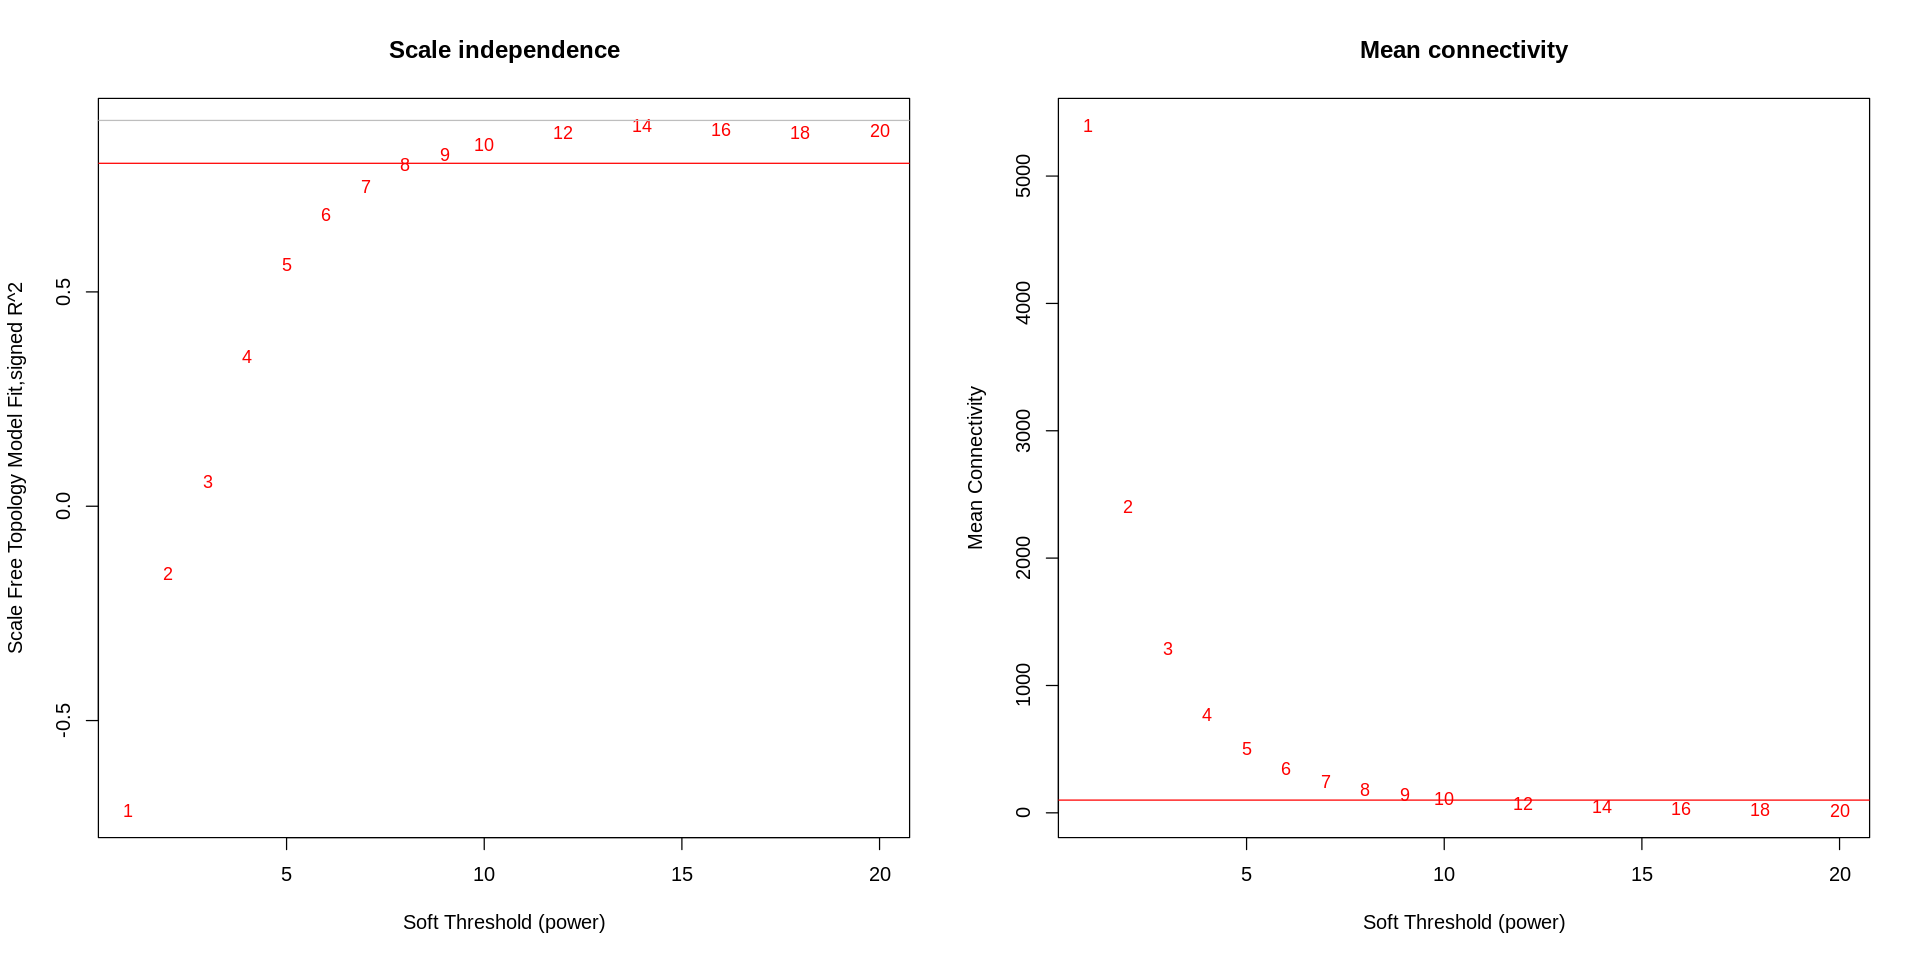

In [23]:
par(mfrow = c(1,2))
cex1 = 0.9
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# to satisfy SFT want R^2 > 0.8, tutorial picks a value around 0.9 R2
abline(h=0.80,col="red")
abline(h=0.90,col="grey")


plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
# to satisfy SFT, mean connectivity should be <100
abline(h=100,col="red")

In [24]:
cor <- WGCNA::cor
#mergeCutHeight = 1 - correlation between modules -> i.e. how much dissimilarity are you allowing between merged modules?
#reassignThreshold = 1 -> when set to 0 will reassign gene to module with higher KME, no matter what the p-value ratio is
net = blockwiseModules(datExpr, power = 7,
                       TOMType = "unsigned", maxBlockSize = 18000, mergeCutHeight = 0.2, reassignThreshold = 0,
                       numericLabels = FALSE, pamRespectsDendro = FALSE,
                       saveTOMs = TRUE, saveTOMFileBase = "allSaltTOM_binary",
                       verbose = 2)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..merging modules that are too close..


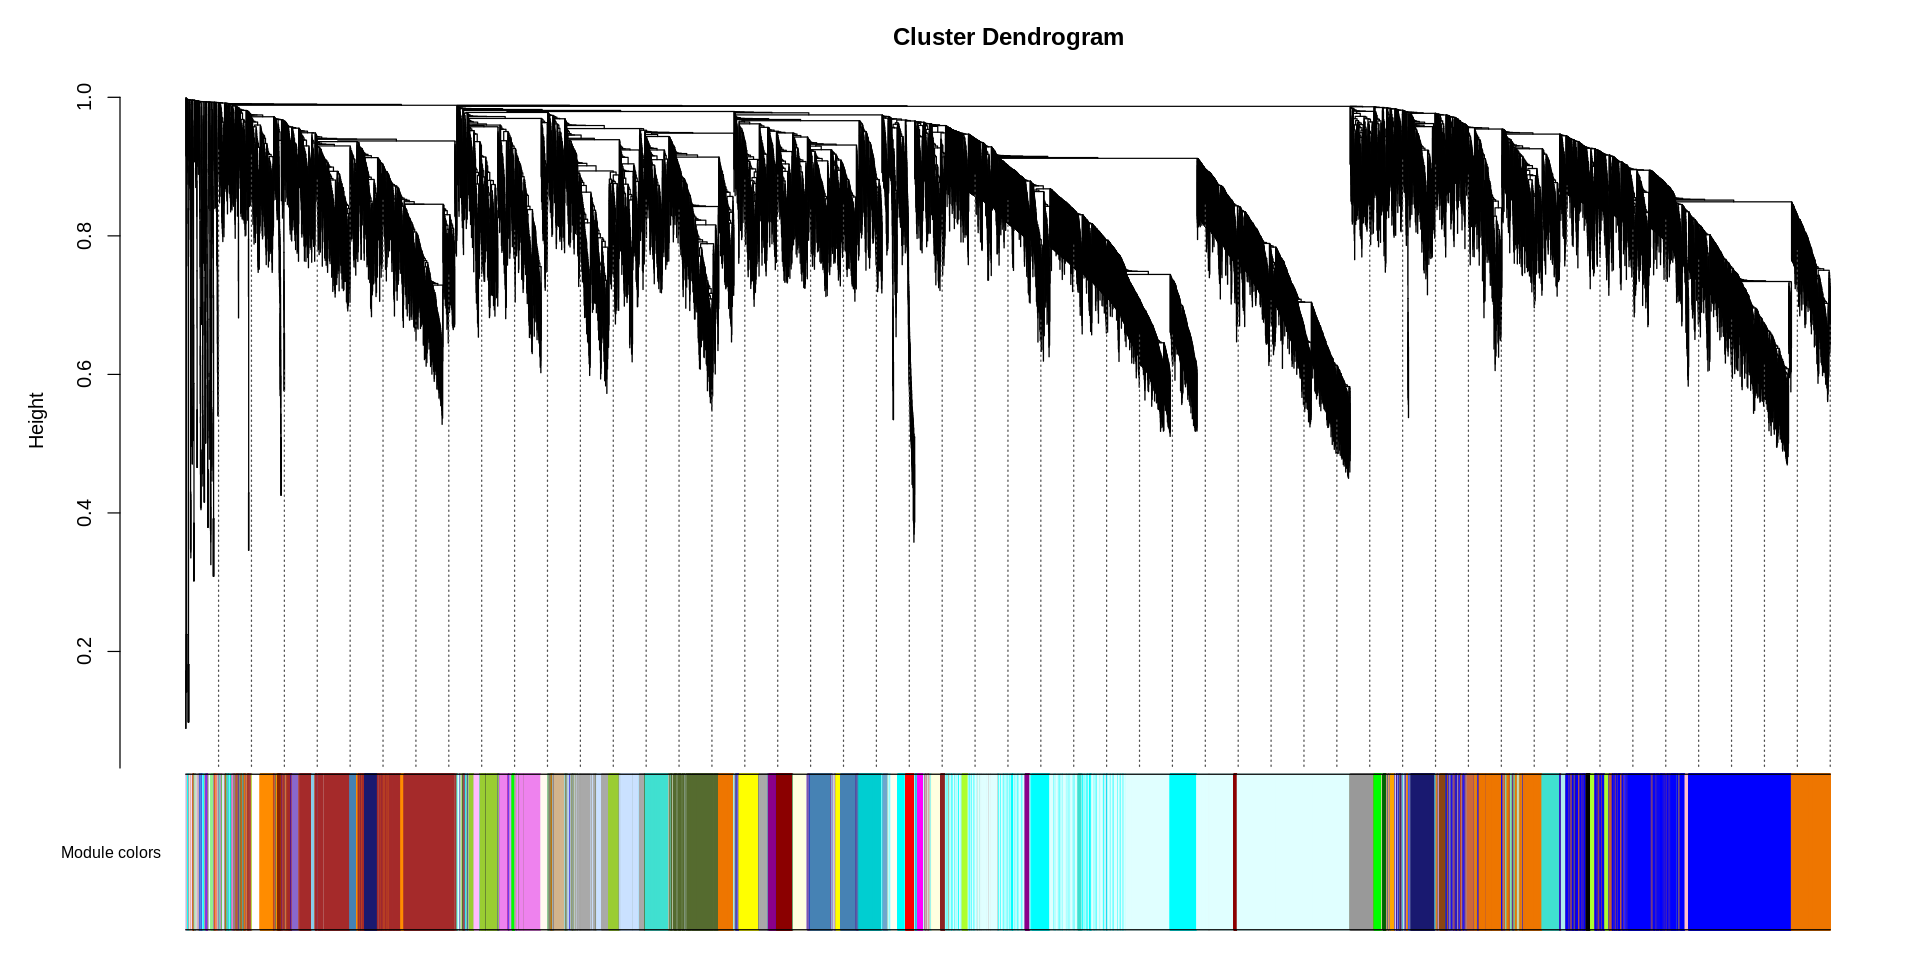

In [25]:
mergedColors = labels2colors(net$colors)
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]], "Module colors",
                    dendroLabels = FALSE,addGuide = TRUE, guideHang = 0.05)

In [26]:
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs;
geneTree = net$dendrograms[[1]]

# Relating modules to external information
This step identifies the important genes and does this by creating a heatmap with the module eigengene colors and the clinical traits 
- Each cell contains the correlation and the p-value between the module eigengene and the traits 

In [27]:
head(datExpr) #Gene x Sample
head(MEs) #PC1 = Sample x Module 
head(datTraits) #Env x Sample
#head(moduleTraitCor) #Cor between datTraits and ME; Env x ME 

ADF43159.1 ADF43160.1 ADF43161.1 ADF43162.1 ADF43163.1 ADF43164.1
X23_00_1 0.6463819   6.453559  4.694451   45.19839   1.5678370  3.2207649 
X23_00_2 0.7206985   5.678646  3.179284   47.48910   0.8512468  0.8449568 
X23_00_3 1.2623981   7.293855  8.149658   35.92979   2.0361259  4.8754683 
X23_05_1 1.2350549  14.351830  3.251458   30.27782   2.9264170  6.6546172 
X23_05_2 1.4448040  16.079879  6.874504   39.41996   1.7606931  7.0014871 
X23_05_3 1.9649550  18.538271  7.360521   51.00341   1.8215097  5.4607180 
         ADF43165.1 ADF43166.1 ADF43167.1 ADF43168.1 ⋯ g9990    g9991    
X23_00_1 1.8760840  0.8249619  0.1962231  0.6117076  ⋯ 7.461870 0.4491209
X23_00_2 0.9562438  0.7358483  0.0000000  0.6944382  ⋯ 9.092336 0.4006062
X23_00_3 2.4632157  1.1372955  0.1803426  1.3288401  ⋯ 9.766491 1.0319330
X23_05_1 3.2251148  2.0390914  0.6381743  1.6639038  ⋯ 6.782085 1.6067385
X23_05_2 2.8755124  0.9834502  1.2475768  1.8562125  ⋯ 6.962780 1.6285212
X23_05_3 2.5749727  1.1393578  0.8247959  1.5360572  ⋯ 6.761060 1.1293187
         g9992    g9993    g9994     g9995    g9996    g9997    g9998   
X23_00_1 7.194420 27.36460 0.9176601 2.136383 1.862785 3.746077 5.038063
X23_00_2 8.811771 30.34868 0.8011175 2.648472 2.764947 4.994906 6.103579
X23_00_3 8.783330 25.06978 1.7585645 2.429395 2.862298 5.146609 7.394704
X23_05_1 5.308280 19.06686 1.7906980 1.578051 1.533511 3.567077 4.035171
X23_05_2 6.955139 12.24906 2.0792947 2.000042 1.827415 4.910799 6.125477
X23_05_3 6.963749 10.47729 1.6296608 1.815566 1.572982 3.872753 6.163393
         g9999   
X23_00_1 2.918422
X23_00_2 3.565210
X23_00_3 4.606441
X23_05_1 4.002959
X23_05_2 3.630362
X23_05_3 5.181166

MElightcyan1 MEivory     MElightyellow MEroyalblue MEviolet   
X23_00_1 -0.05358958  -0.05111813 -0.1331442    -0.1775278  -0.08413078
X23_00_2 -0.04923308  -0.04329933 -0.1268361    -0.1716442  -0.08749020
X23_00_3  0.00516733  -0.02454802 -0.1327773    -0.1884444  -0.06477802
X23_05_1 -0.05238942  -0.04646776 -0.1414151    -0.1804156  -0.04143719
X23_05_2 -0.02879479  -0.02800610 -0.1240093    -0.1665475  -0.02319215
X23_05_3 -0.03884054  -0.04869662 -0.1055779    -0.1405668  -0.01877676
         MEgreen     MEsienna3   MEfloralwhite MEdarkorange2 MEturquoise ⋯
X23_00_1 -0.11392486 -0.12416280 -0.04997455   -0.03538135   -0.12331260 ⋯
X23_00_2 -0.11338903 -0.06429829 -0.01582265   -0.03201622   -0.13264171 ⋯
X23_00_3 -0.09541404 -0.01002440 -0.05571080   -0.03431170   -0.13169978 ⋯
X23_05_1 -0.11622699 -0.19321195 -0.04754655   -0.05121649   -0.09928905 ⋯
X23_05_2 -0.11003572 -0.09465313 -0.04001470   -0.03037289   -0.11014611 ⋯
X23_05_3 -0.10561386 -0.05433573 -0.03997652   -0.05060683   -0.11687273 ⋯
         MEyellowgreen MEsaddlebrown MEyellow    MEdarkmagenta MEmediumpurple3
X23_00_1 -0.03886853    0.08313077    0.03421750  0.0514891816  0.02708199    
X23_00_2 -0.07551027    0.11476945    0.03524718 -0.0008411035 -0.01675108    
X23_00_3 -0.11181023    0.04302205   -0.01864243 -0.0843444583 -0.09449278    
X23_05_1  0.17489125   -0.09592553   -0.04675223  0.1293563182  0.15036033    
X23_05_2  0.14041385   -0.08196105   -0.04274741 -0.0735506125 -0.11995667    
X23_05_3  0.19797446   -0.05131183   -0.02130356 -0.0828443567 -0.16375335    
         MEdarkred   MEorange      MEblue      MEdarkolivegreen MEgrey     
X23_00_1 -0.03900031 -0.1413567169 -0.07356433 -0.090860608      0.04889550
X23_00_2 -0.02014255 -0.1028386027 -0.06630298 -0.052887546     -0.08148052
X23_00_3 -0.04223558 -0.0863562243 -0.11348787 -0.075882910     -0.04198679
X23_05_1 -0.03176287 -0.1444846935 -0.08735582 -0.065757653      0.10826694
X23_05_2 -0.01107182 -0.0407006819 -0.09152319 -0.018301349     -0.09971385
X23_05_3  0.02570490 -0.0004733453 -0.06581854 -0.001855329     -0.50137933

Conc.0 Conc.5 Conc.36 Evolved Ancestor X29 X23 X2935 X40 X54
X23_00_1 1      0      0       1       0        0   1   0     0   0  
X23_00_2 1      0      0       1       0        0   1   0     0   0  
X23_00_3 1      0      0       1       0        0   1   0     0   0  
X23_05_1 0      1      0       1       0        0   1   0     0   0  
X23_05_2 0      1      0       1       0        0   1   0     0   0  
X23_05_3 0      1      0       1       0        0   1   0     0   0

In [28]:
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, datTraits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

In [29]:
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                        signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)

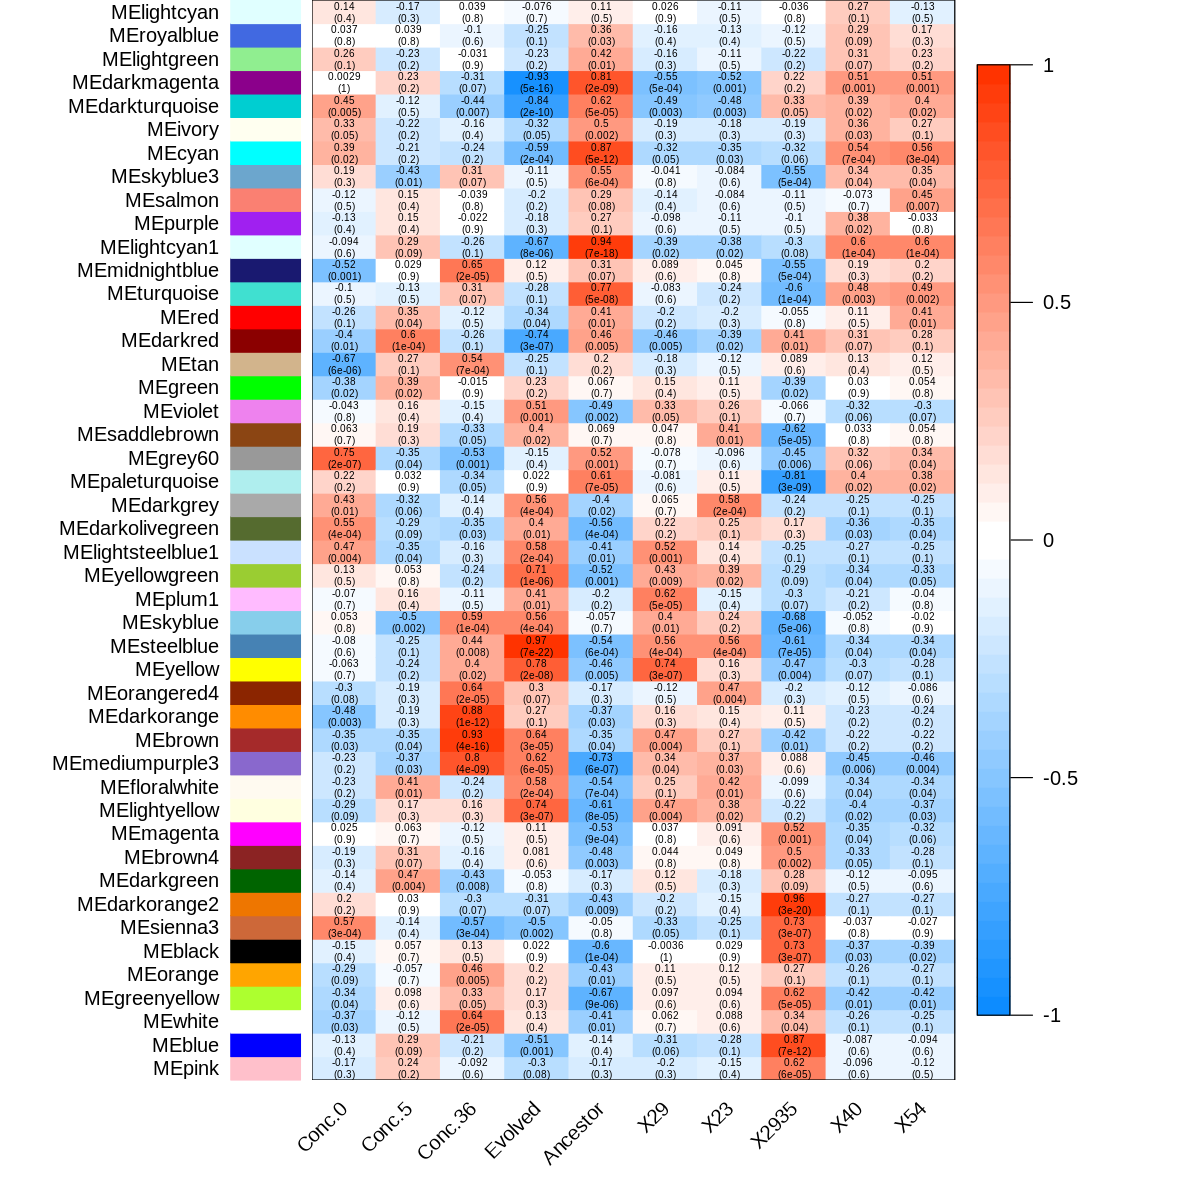

In [30]:
options(repr.plot.width=10, repr.plot.height=10)
par(mar=c(5, 13, 0, 5)) 
labeledHeatmap(Matrix = moduleTraitCor,
             xLabels = names(datTraits),
             yLabels = names(MEs),
             ySymbols = names(MEs),
             colorLabels = FALSE,
             colors = blueWhiteRed(50),
             textMatrix = textMatrix,
             setStdMargins = FALSE,
             cex.text = .5,
             zlim = c(-1,1))
options(repr.plot.width=16, repr.plot.height=8)

# Visualize Correlations between modules

In [31]:
Evolved = as.data.frame(datTraits$Evolved)
names(Evolved) = "Evolved"

Ancestor = as.data.frame(datTraits$Ancestor)
names(Ancestor) = "Ancestor"

Conc.0 = as.data.frame(datTraits$Conc.0)
names(Conc.0) = "Conc.0"

Conc.5 = as.data.frame(datTraits$Conc.5)
names(Conc.5) = "Conc.5"

Conc.36 = as.data.frame(datTraits$Conc.36)
names(Conc.36) = "Conc.36"

X2935 = as.data.frame(datTraits$X2935)
names(X2935) = "X2935"


Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”


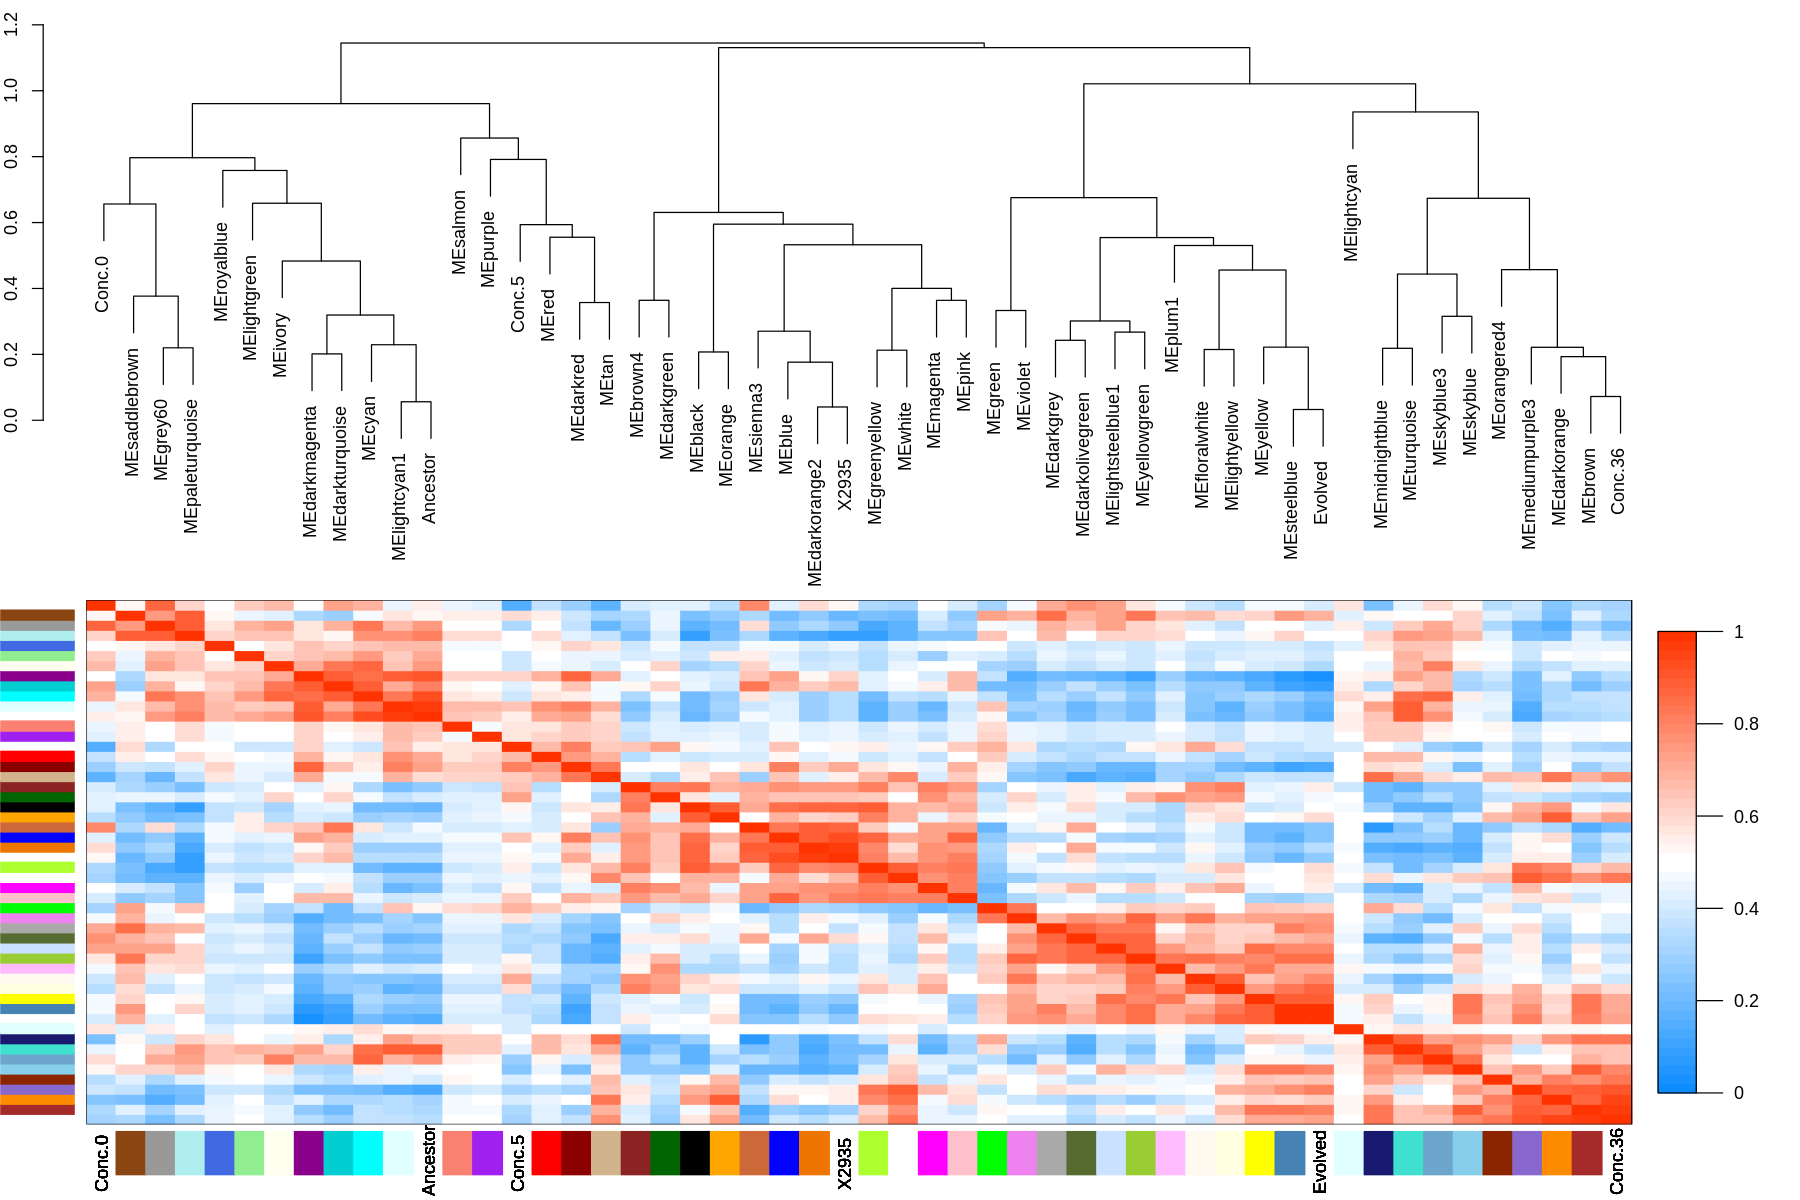

In [32]:
options(repr.plot.width=15, repr.plot.height=10)
MET = orderMEs(cbind(MEs, Evolved, Ancestor, Conc.0, Conc.5, Conc.36, X2935))
# Plot the relationships among the eigengenes and the trait
par(cex = 0.9)
                                # bottom, left, top and right
plotEigengeneNetworks(MET, "", marDendro = c(0,2,1,5.5), 
                              marHeatmap = c(3.5,4,0,1), xLabelsAngle = 90, xLabelsAdj = 0.3)

# Identify Hub Genes
Find genes in the top 5% that have a higher connectivity than the average

In [33]:
modules <- unique(moduleColors)
length(modules)

[1] 46

In [34]:
counter = 0
probes = names(datExpr) #genes
hubs = rep(NA,length(modules))
names(hubs) = modules
for (m in modules){
    inModule = (moduleColors==m)
    modProbes = probes[inModule]
    nTop = round(length(modProbes) * 0.05)
    temp <- datExpr[, modProbes]
    IMConn = softConnectivity(temp)
    top = (rank(-IMConn) <= nTop) #TF df
    greater_avg <- IMConn >= mean(IMConn) #TF df to see the genes with higher connectivity than average
    hubs[m] = list(names(temp[greater_avg & top]))
    counter = counter + length(names(temp[top]))
}
hubs
counter #number of genes is the same with top 5% and higher than avg

 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less than 12 valid samples will be returned as NA.
 ..calculating connectivities.. 
 softConnectivity: FYI: connecitivty of genes with less

$darkorange2
 [1] "Cre01.g026600" "Cre01.g028777" "Cre02.g073850" "Cre02.g085100"
 [5] "Cre02.g085850" "Cre02.g097150" "Cre02.g099050" "Cre03.g150900"
 [9] "Cre05.g238140" "Cre07.g327400" "Cre07.g354250" "Cre09.g399050"
[13] "Cre09.g399200" "Cre09.g403950" "Cre10.g417600" "Cre12.g528300"
[17] "Cre12.g536250" "Cre12.g545700" "Cre12.g549550" "Cre13.g563400"
[21] "Cre13.g574350" "Cre13.g578700" "Cre13.g579250" "Cre13.g580100"
[25] "Cre13.g582100" "Cre14.g618500" "Cre14.g628150" "Cre15.g639379"
[29] "Cre15.g643050" "Cre16.g666302" "Cre16.g666500" "Cre17.g704500"
[33] "Cre17.g707600" "Cre17.g724550" "g10934"        "g10948"       
[37] "g11142"        "g11705"        "g11717"        "g11719"       
[41] "g11723"        "g12144"        "g12208"        "g1251"        
[45] "g12784"        "g12796"        "g13024"        "g14333"       
[49] "g14672"        "g14681"        "g14770"        "g14914"       
[53] "g16716"        "g16825"        "g16887"        "g17772"       
[57] "g18177"        "g18214"        "g18215"        "g1822"        
[61] "g18326"        "g2113"         "g2700"         "g2772"        
[65] "g4599"         "g5621"         "g6267"         "g7072"        
[69] "g8673"         "g8711"         "g8746"         "g8758"        
[73] "g8763"         "g8764"         "g8777"         "g9126"        
[77] "g9327"         "g9570"         "g9733"        

$lightyellow
 [1] "Cre01.g012350" "Cre01.g031750" "Cre02.g082300" "Cre06.g254150"
 [5] "Cre10.g466250" "Cre10.g466450" "Cre12.g499000" "Cre12.g502800"
 [9] "Cre12.g529500" "Cre12.g540200" "Cre16.g662000" "g10587"       
[13] "g9781"        

$yellowgreen
 [1] "ADF43193.1"    "Cre03.g169100" "Cre03.g199050" "Cre03.g201550"
 [5] "Cre03.g201950" "Cre03.g204500" "Cre06.g300500" "Cre07.g349750"
 [9] "Cre08.g358850" "Cre08.g385550" "Cre09.g397700" "Cre10.g449000"
[13] "Cre10.g453500" "Cre13.g605900" "Cre17.g703200" "Cre17.g718500"
[17] "g11550"        "g14321"        "g16469"        "g5732"        

$lightcyan1
  [1] "ChrepMp03"     "ChrepMp04"     "ChrepMp05"     "ChrepMp06"    
  [5] "ChrepMp07"     "ChrepMp08"     "ChrepMr22"     "ChrepMt23"    
  [9] "ChrepMt24"     "Cre01.g002050" "Cre01.g002600" "Cre01.g048600"
 [13] "Cre02.g104400" "Cre02.g108400" "Cre02.g141850" "Cre02.g143392"
 [17] "Cre03.g151950" "Cre03.g153250" "Cre03.g153400" "Cre03.g155650"
 [21] "Cre03.g159850" "Cre03.g160100" "Cre03.g163500" "Cre03.g166350"
 [25] "Cre03.g168786" "Cre03.g172322" "Cre03.g176950" "Cre03.g177100"
 [29] "Cre03.g177900" "Cre03.g179000" "Cre03.g179350" "Cre03.g179400"
 [33] "Cre03.g180600" "Cre03.g184650" "Cre03.g187350" "Cre03.g206900"
 [37] "Cre04.g214800" "Cre04.g228500" "Cre05.g241600" "Cre05.g242178"
 [41] "Cre05.g248500" "Cre06.g256350" "Cre06.g262350" "Cre06.g266300"
 [45] "Cre06.g269550" "Cre06.g271950" "Cre06.g273750" "Cre06.g273800"
 [49] "Cre06.g276250" "Cre06.g276350" "Cre06.g277000" "Cre06.g280700"
 [53] "Cre06.g281650" "Cre06.g282150" "Cre06.g295100" "Cre07.g323350"
 [57] "Cre07.g342500" "Cre07.g344172" "Cre07.g345031" "Cre07.g345950"
 [61] "Cre08.g365950" "Cre08.g370850" "Cre08.g374950" "Cre09.g391600"
 [65] "Cre09.g406650" "Cre10.g422550" "Cre10.g423750" "Cre10.g426643"
 [69] "Cre10.g426950" "Cre10.g431400" "Cre10.g437450" "Cre10.g442050"
 [73] "Cre10.g444100" "Cre11.g476900" "Cre12.g507200" "Cre12.g555850"
 [77] "Cre12.g556550" "Cre14.g621100" "Cre14.g634113" "Cre15.g641800"
 [81] "Cre16.g655850" "Cre16.g660331" "Cre16.g667050" "Cre16.g676350"
 [85] "Cre16.g679500" "Cre16.g682350" "Cre16.g685628" "Cre17.g698200"
 [89] "Cre17.g698683" "Cre17.g699400" "Cre17.g699950" "Cre17.g720850"
 [93] "Cre17.g723300" "Cre17.g726000" "Cre17.g727400" "Cre17.g736100"
 [97] "Cre17.g736350" "Cre17.g739515" "Cre17.g739700" "g10212"       
[101] "g11830"        "g12153"        "g13393"        "g13778"       
[105] "g14664"        "g14718"        "g15107"        "g15191"       
[109] "g15525"        "g16136"        "g16137"        "g16154"       
[113] "g16313"        "g16363"        "g17774"   

[1] 884

In [ ]:
capture.output(hubs, file = "hubs_top5.txt")

# Annotating Gene Lists

## Get module data

In [35]:
df <- data.frame(colors = modules, genes = "", count = 0)
for (color in 1:length(modules)){
    genes <- names(datExpr)[moduleColors==modules[color]]
    df[color, 2] <- paste(unlist(list(genes)), collapse = ", ")
    df[color, 3] <- length(genes)
}
write.csv(df, file = "module_genes_binary7_BS18000.csv")

## Convert to 5.5

In [36]:
module_genes <- read.csv(file = "module_genes_binary7_BS18000.csv")[-1]
module_genes$genes_5_5 <- ""
head(module_genes)

colors     
1 darkorange2
2 lightyellow
3 yellowgreen
4 lightcyan1 
5 brown      
6 yellow     
  genes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [44]:
source("../Reference_Files/Name_Conversion/Gene_Conversion_Functions.r")

In [45]:
for (row in 1:nrow(module_genes)){
    converted_names <- name_conversion(unlist(strsplit(module_genes[row, 2], split = ", ")))
    module_genes[row, 4] <- paste(converted_names[!is.na(converted_names)], collapse = ", ")
}
head(module_genes)
write.csv(module_genes, file = "module_genes_binary7_BS18000.csv")

colors     
1 darkorange2
2 lightyellow
3 yellowgreen
4 lightcyan1 
5 brown      
6 yellow     
  genes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Run topGO

In [47]:
source("../Reference_Files/Annotation_Files/topGO_Annotation.r")

In [48]:
storage_main <- data.frame(i=integer(), Annotation = I(list()))
for (row in 1:nrow(module_genes)){
    myInterestingGenes <- unlist(strsplit(module_genes[row, "genes_5_5"], split = ", "))
    storage_main <- rbind(storage_main, RunTopGO(myInterestingGenes, row))
}


Building most specific GOs .....

	( 1561 GO terms found. )


Build GO DAG topology ..........

	( 2076 GO terms and 2647 relations. )


Annotating nodes ...............

	( 7699 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 616 nontrivial nodes
		 parameters: 
			 test statistic: fisher


Building most specific GOs .....

	( 2292 GO terms found. )


Build GO DAG topology ..........

	( 4294 GO terms and 9231 relations. )


Annotating nodes ...............

	( 6161 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 1633 nontrivial nodes
		 parameters: 
			 test statistic: fisher


Building most specific GOs .....

	( 541 GO terms found. )


Build GO DAG topology ..........

	( 770 GO terms and 1358 relations. )


Annotating nodes ...............

	( 5575 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 319 nontrivial nodes
		 parameters: 
			 test 

In [49]:
head(storage_main)

i Annotation  
1 1 c("GO:00....
2 2 c("GO:00....
3 3 c("GO:01....
4 4 c("GO:00....
5 5 c("GO:00....
6 6 c("GO:00....

In [ ]:
module_genes_GO <- merge(module_genes, storage_main[-1], by = 0)
rownames(module_genes_GO) <- module_genes_GO$colors
module_genes_GO <- module_genes_GO[-1]
head(module_genes_GO)

## Summarise Annotation Data

In [ ]:
module_genes_GO_copy <- module_genes_GO
module_genes_GO_copy$count_summary <- ""
module_genes_GO_copy$pval_summary <- ""
module_genes_GO_copy$Correlation <- 0
module_genes_GO_copy$Group <- ""
moduleTraitCor_df <- data.frame(moduleTraitCor)
rownames(moduleTraitCor_df) <- gsub("ME", "", rownames(moduleTraitCor_df))

for (row in 1:nrow(module_genes_GO_copy)){
    #Get annotation
    Annotation <- module_genes_GO_copy[row, "Annotation"][[1]]
    summarized <- summariseGO(Annotation)
    module_genes_GO_copy[row, "count_summary"] <- summarized["count_summary"]
    module_genes_GO_copy[row, "pval_summary"] <- summarized["pval_summary"]
    
    #get group with highest absolute correlation and it's value
    color <- module_genes_GO_copy[row, "colors"]
    index <- which.max(abs(moduleTraitCor_df[color,]))
    module_genes_GO_copy[row, "Correlation"] <- moduleTraitCor_df[color,index]
    module_genes_GO_copy[row, "Group"] <- names(index)
}

In [ ]:
summarised_module_genes_GO <- module_genes_GO_copy[, c("colors", "Correlation", "Group", "count_summary", "pval_summary")]
summarised_module_genes_GO

## Subset Highly correlated genes

In [ ]:
summarised_module_genes_GO %>%
    filter(abs(Correlation) >= 0.75)%>%
    arrange(desc(Correlation))

# Extra Code 